In [39]:
import torch
import torch_geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import global_mean_pool

import torchmetrics
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = TUDataset('data/PROTEINS_full', name='PROTEINS_full')
dataset = dataset.shuffle()
train_dataset = dataset[:500]
test_dataset = dataset[500:]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [3]:
class GATv2Classifier(torch.nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dim=16, hidden_layers=1, heads=4):
        super().__init__()
        conv_layers = [GATv2Project(input_dim, hidden_dim, heads),]
        conv_layers = conv_layers + [GATv2Project(hidden_dim, hidden_dim, heads) for _ in range(hidden_layers-1)]
        self.conv_layers = torch.nn.ModuleList(conv_layers)
        self.linear = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        for layer in self.conv_layers:
            x = layer(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.linear(x)
        return x

class GATv2Project(torch.nn.Module):

    def __init__(self, in_channels, out_channels, heads) -> None:
        super().__init__()
        self.gatv2 =  GATv2Conv(in_channels=in_channels, out_channels=out_channels, heads=heads)
        self.projection = torch.nn.Linear(heads * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.gatv2(x, edge_index)
        x = self.projection(x)
        return x

In [24]:
def train_epoch(model, train_loader, criterion, optimiser):
    # initialise epoch
    accuracy = torchmetrics.Accuracy()
    epoch_loss = []
    model.train()

    for batch in train_loader:
        # predict
        yhat = model(batch.x, batch.edge_index, batch.batch).squeeze()

        # update metrics
        accuracy.update(yhat, batch.y)
        loss = criterion(yhat, batch.y.float())
        epoch_loss.append(loss)

        # gradient update
        loss.mean().backward()
        optimiser.step()
        optimiser.zero_grad()
    
    # compute metrics over epoch
    epoch_loss = torch.cat(epoch_loss).mean().item()
    epoch_acc = accuracy.compute().item()
    return epoch_loss, epoch_acc

def validate(model, loader, criterion):
    # initialise epoch
    accuracy = torchmetrics.Accuracy()
    epoch_loss = []
    model.eval()

    for batch in loader:
        # predict
        yhat = model(batch.x, batch.edge_index, batch.batch).squeeze()

        # update metrics
        accuracy.update(yhat, batch.y)
        loss = criterion(yhat, batch.y.float())
        epoch_loss.append(loss)
        
    # compute metrics over epoch
    epoch_loss = torch.cat(epoch_loss).mean().item()
    epoch_acc = accuracy.compute().item()
    return epoch_loss, epoch_acc

In [42]:
model = GATv2Classifier(input_dim=3, output_dim=1, hidden_dim=128, hidden_layers=1, heads=4)
criterion = torch.nn.BCEWithLogitsLoss(reduction='none')
optimiser = torch.optim.Adam(model.parameters())

In [44]:
metrics = []
for epoch in range(1000):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimiser)
    test_loss, test_acc = validate(model, test_loader, criterion)
    metrics.append((train_loss, test_loss, train_acc, test_acc))
    if epoch % 10:
        print(metrics[-1])
metrics = np.array(metrics)

(0.6646276712417603, 0.6501602530479431, 0.5979999899864197, 0.6394779682159424)
(0.6655285358428955, 0.6522513628005981, 0.6060000061988831, 0.6476345658302307)
(0.6655147075653076, 0.6491744518280029, 0.5960000157356262, 0.636215329170227)
(0.6656132340431213, 0.64694744348526, 0.5979999899864197, 0.6329526901245117)
(0.671526312828064, 0.6518483757972717, 0.6019999980926514, 0.6476345658302307)
(0.6674560904502869, 0.6463528871536255, 0.5979999899864197, 0.6280587315559387)
(0.6655867695808411, 0.6498852968215942, 0.5920000076293945, 0.636215329170227)
(0.6659433841705322, 0.6530200839042664, 0.5979999899864197, 0.646003246307373)
(0.6648703813552856, 0.6479694843292236, 0.5979999899864197, 0.636215329170227)
(0.6663309335708618, 0.6495915651321411, 0.593999981880188, 0.646003246307373)
(0.6658560633659363, 0.6494688987731934, 0.6039999723434448, 0.6411092877388)
(0.6649437546730042, 0.6469500660896301, 0.5979999899864197, 0.6378466486930847)
(0.6673836708068848, 0.6463516354560852,

KeyboardInterrupt: 

(<matplotlib.legend.Legend at 0x7f2b80594dc0>,
 <matplotlib.legend.Legend at 0x7f2b805bf4c0>)

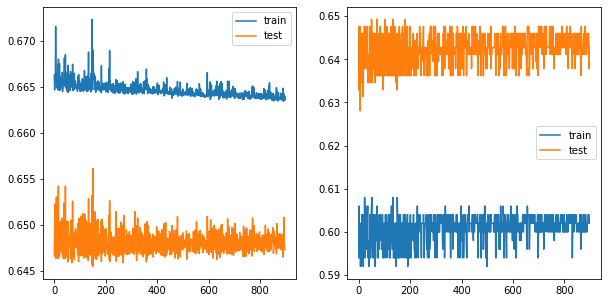

In [47]:
metrics = np.array(metrics)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(metrics[:, 0], label='train')
ax[0].plot(metrics[:, 1], label='test')
ax[1].plot(metrics[:, 2], label='train')
ax[1].plot(metrics[:, 3], label='test')
ax[0].legend(), ax[1].legend()

In [46]:
metrics[:, 0]

TypeError: list indices must be integers or slices, not tuple